In [1]:
# Cell A: imports and settings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell B: load and quick EDA

df = pd.read_csv(r"D:\project workspace\Credit_card_Fraud_Detection_Model\creditcard.csv")

print("Shape:", df.shape)
print(df['Class'].value_counts())
print(df.info())
df.head()



Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Cell C: missing values and amount stats

print("Missing values per column:\n", df.isnull().sum())
print("\nAmount stats by class:")
df.groupby('Class')['Amount'].describe().T



Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Amount stats by class:


Class,0,1
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


In [4]:
# Cell D: split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test distribution:\n", y_test.value_counts(normalize=True))


Train: (227845, 30) Test: (56962, 30)
Train distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [5]:
# Cell E: upgraded pipeline for max F1

pipe = ImbPipeline([
    ('sampler', SMOTETomek(
        sampling_strategy=0.05,   # key improvement
        random_state=42
    )),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])


In [6]:
# Cell F: GridSearchCV

param_grid = {
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [4, 6],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_pipe = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Best CV F1: 0.8522875252692718


In [7]:
# Cell G: predictions

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]


In [8]:
# Cell H: threshold tuning

thresholds = np.arange(0.05, 0.9, 0.01)
best_f1, best_t = 0, 0

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best Threshold:", best_t)
print("Best F1:", best_f1)


Best Threshold: 0.7300000000000002
Best F1: 0.8723404255319149


In [9]:
# Cell I: final evaluation

final_preds = (y_proba >= best_t).astype(int)

print("Accuracy:", accuracy_score(y_test, final_preds))
print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1:", f1_score(y_test, final_preds))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))


Accuracy: 0.9995786664794073
Precision: 0.9111111111111111
Recall: 0.8367346938775511
F1: 0.8723404255319149
ROC AUC: 0.9895066495928703

Confusion Matrix:
 [[56856     8]
 [   16    82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
# Cell J: save model

joblib.dump(best_pipe, "fraud_detection_best_pipeline.pkl")
print("Model saved successfully")


Model saved successfully


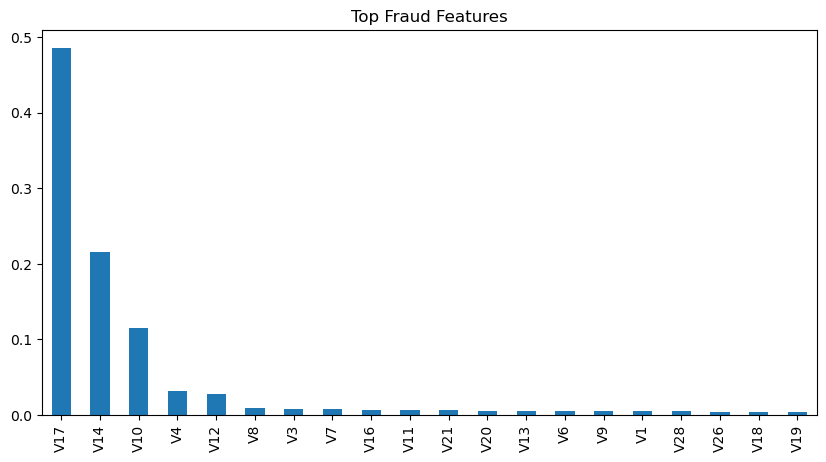

In [11]:
# Cell K: feature importance

importances = best_pipe.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

feat_imp.head(20)
feat_imp.head(20).plot.bar(figsize=(10,5), title="Top Fraud Features")
plt.show()


In [12]:
y_pred_new = best_pipe.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_new = accuracy_score(y_test, y_pred_new)
print("New Model Test Accuracy:", accuracy_new)

New Model Test Accuracy: 0.9994557775359011


Using estimator: Pipeline(steps=[('sampler',
                 SMOTETomek(random_state=42, sampling_strategy=0.05)),
                ('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature...ghts=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4

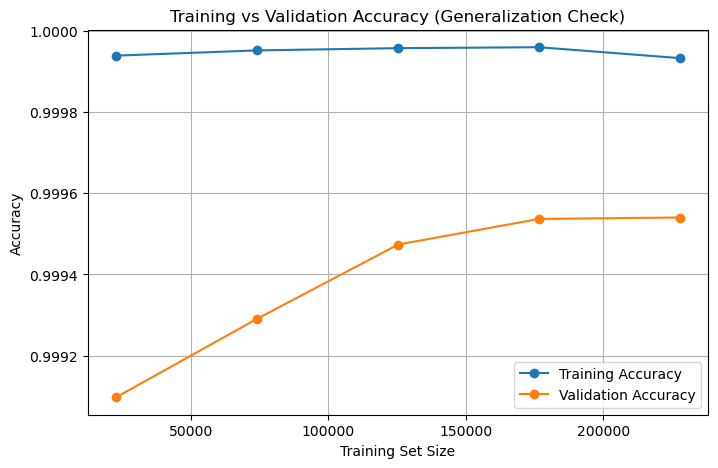

In [13]:
# Cell M: Training vs Validation Accuracy (Generalization Plot)

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Make sure best_pipe exists
print("Using estimator:", best_pipe)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_pipe,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

# Mean accuracy
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Generalization Check)")
plt.legend()
plt.grid(True)
plt.show()

